In [ ]:
from wtlike import *

# wtlike tutorial

> A step by step guide

### Install `wtlike`

This assumes that you already have a Jupyter Notebook Server configured on your machine. 

`wtlike` is on PyPI

```
pip install wtlike
```
We use a simulated on-the-fly dataset in lieu of downloading the 2-GB file with all of *fermi* data.

### Define a source flux function. 
Note that we measure time in day units, and will pick a 30-day interval for this demo.

The following function has a flare at 15 days.

In [ ]:
def src_flare(t, tzero=15, width=1, amp=5):
    return 1e-6*(1 + amp*np.exp(-(t-tzero)**2/2/width))

We use it to tell the simulation that the flux has this behavior. Note defaults:

- background -- 1e-6 /s
- exposure rate -- 3000 cm^2 

Here we create a `Simulation` object, then pass it to the primary wtlike entry point, the class `WtLike`.
We tell it to immediately bin the photons into daily time-bins, called "cells". (That can be easily redone.)

In [ ]:
test_sim = Simulation('flare_sim', src_rate=src_flare, tstart=0, tstop=30, )
daily = WtLike(test_sim, time_bins=(0,0,1))

generated 18849 photons
SourceData: Source flare_sim with:
	 data:        18,849 simulated photons over 30.0 days.
	 exposure:     8,640 intervals,  average rate 3000 cm^2 for 2.6 Ms
	 rates:  source 1.42e-06/s, background 9.99e-07/s, S/N ratio 1.43
CellData: Bin photon data into 30 1-day bins from 0.0 to 30.0
LightCurve: select 30 cells for fitting with e>10 & n>2


Now make a light curve!

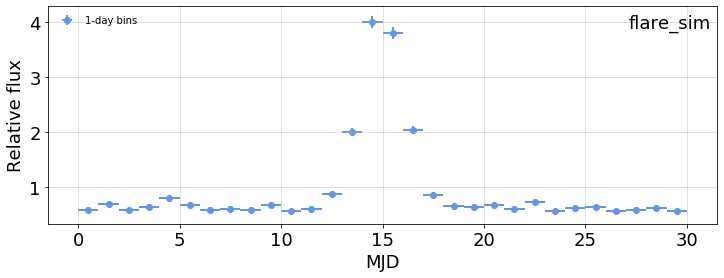

In [ ]:
daily.plot();

The cells have each been analyzed to create a likelihood function representation. The first few cells are:

In [ ]:
daily.cells.head(2)

,t,tw,e,n,w,S,B
0,0.5,1.0,258.3,531,"[0.8769002, 0.83002424, 0.79095143, 0.01642000...",368.04,258.08
1,1.5,1.0,259.2,549,"[0.8949514, 0.002101088, 0.85367936, 0.7689916...",369.32,258.98


The Kerr likelihood function for a cell is a function of $w$, the list of weights, and $S$, an estimate for the total signal counts in the cell

$$ \displaystyle\log\mathcal{L}(\alpha\ |\ w)\ = \sum_{w}  \log \big( 1 + \alpha\ w \big) - \alpha\ S  $$

where $\alpha$ is the variation from the nominal zero. The background is assumed to be constant here, as it usually is the region surrounding sources of interest. 
The relative flux is $1+\alpha$. 

We generate an approximate representation of this function by fitting it to a 3-parameter Poisson-like function, which easily provides the values of interest.

In [ ]:
daily.fluxes.head(2)

,t,tw,n,ts,flux,errors,limit
0,0.5,1.0,531,348.9,0.60,"(-0.048, 0.05)",0.68
1,1.5,1.0,549,446.0,0.69,"(-0.051, 0.052)",0.78


Note that the properties `photons`, `exposure`, `cells`, `fits`, and `fluxes` are [DataFrames](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). So we can find a fit at the peak with a `query`.

In [ ]:
daily.fluxes.query('flux>3')

,t,tw,n,ts,flux,errors,limit
14,14.5,1.0,1641,9847.4,4.00,"(-0.105, 0.107)",4.17
15,15.5,1.0,1565,9275.1,3.79,"(-0.103, 0.104)",3.97


## Views
A `WtLike` object provides a function `view`, which returns a **new** instance with a different binning. 
So if we want a detailed look at the flare, we can choose an interval as so:

CellData: Bin photon data into 40 6-hour bins from 10.0 to 20.0
LightCurve: select 40 cells for fitting with e>10 & n>2


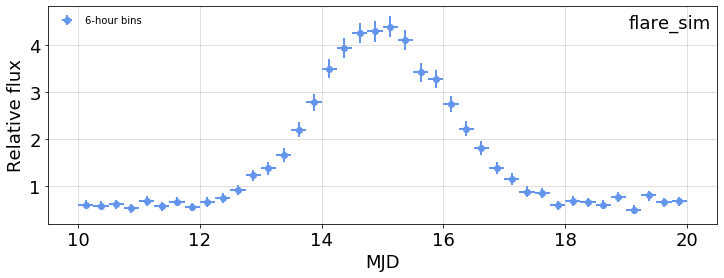

In [ ]:
qday = daily.view((10,-10, 0.25))
qday.plot();

### Bayesian-Block view
The WtLike object also has a special `bb_view` function, which does a Bayesian Block analysis and returns a view of it. 

LightCurve: select 40 cells for fitting with e>10 & n>2
Partitioned 40 cells into 9 blocks, using LikelihoodFitness 
LightCurve: Loaded 9 / 9 cells for fitting


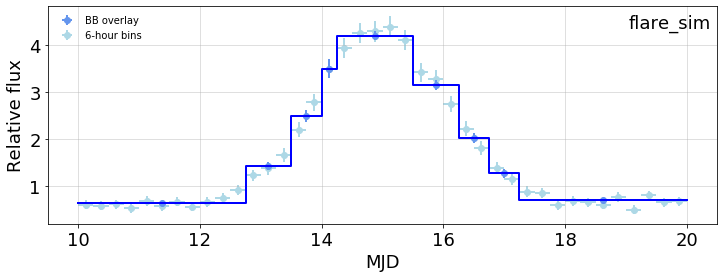

In [ ]:
bb = qday.bb_view();bb.plot();

This creates variable-sized cells corresponding to the Bayesian Block analysis, the fits for which are shown here:

In [ ]:
bb.fluxes

,t,tw,n,ts,flux,errors,limit
0,11.38,2.75,1396,1152.6,0.64,"(-0.029, 0.03)",0.69
1,13.12,0.75,572,1327.2,1.42,"(-0.076, 0.078)",1.55
2,13.75,0.50,553,2318.6,2.49,"(-0.119, 0.122)",2.70
3,14.12,0.25,357,2008.4,3.49,"(-0.195, 0.202)",3.84
4,14.88,1.25,2141,13325.4,4.20,"(-0.096, 0.098)",4.36
5,15.88,0.75,1017,5138.0,3.15,"(-0.108, 0.111)",3.33
6,16.50,0.50,476,1643.8,2.01,"(-0.108, 0.111)",2.20
7,17.00,0.50,363,714.5,1.26,"(-0.088, 0.091)",1.42
8,18.62,2.75,1436,1275.1,0.69,"(-0.03, 0.031)",0.74


### Getting help
This jupyterlab environment allows easy exploration of help for any class or function.
The two classes so far:

In [ ]:
Simulation = Simulation
Simulation?

Init signature:
Simulation(
    name,
    src_rate,
    tstart,
    tstop,
    bkg_rate=1e-06,
    efun=3000,
    wt_signif=0.1,
)
Docstring:      <no docstring>
Init docstring:
- src_rate : source flux, scalar or function of days, typically around 1e-7
- tstart, tstop :(days)
- bkg_rate : background flux, scalar or function of day, typicaly 1e-6 for 4-deg cone
- efun : scalar, function (of time in days) of the exposure/s. Typically 3000 cm^2 for fermi

- wt_signif : now the width of the PSF in (r/rmax)**2 coordinates
File:           /mnt/c/users/thbur/OneDrive/work/wtlike/wtlike/simulation.py
Type:           type
Subclasses:     


In [ ]:
WtLike?

Init signature: WtLike(*pars, **kwargs)
Docstring:     
Summary
---------
There are three layers of initialization, implemented in superclasses,
each with parameters. The classnames, associated parameters and data members set:

SourceData -- load photons and exposure
    parameters:
      - source : name, a PointSource object, or a Simulation object
      - config [Config()] : basic configuration
      - week_range [None] : range of weeks to load
      - key [''] : the cache key: '' means construct one with the source name, None to disable
      - clear [False] : if using cache, clear the contents first
    sets:
      - photons
      - exposure

CellData -- create cells
    parameters:
      - time_bins [Config().time_bins] : binning: start, stop, binsize
    sets:
      - cells

LightCurve -- likelihood analysis of the cells
    parameters:
      - e_min [10] -- threshold for exposure (cm^2 units)
      - n_min [2]  -- likelihood has trouble with this few
      - lc_key [None] -- pos

The three WtLike methods have (preliminary) help as well:

In [ ]:
WtLike.plot?

Signature: WtLike.plot(self, *pars, **kwargs)
Docstring:
Make a light curve plot
    Invokes flux_plot, after processing kwargs to intercept
    - log -- translate to `xscale='log'`
    - xlim -- convert to (start, stop) interpreted relative to start, stop if < start.
    Make a plot of flux vs. time. This is invoked by the `plot` function of `LightCurve`

- cell_fits -- cell fits DataFrame
- ts_min -- threshold for ploting point
- ts_bar_min -- threshold for plotting as bar vs limit
- tzero -- time offset, in MJD
- source_name -- draw text in top left

- ax [None] -- a matplotlib.axes._subplots.AxesSubplot object returned from plt.subplots<br>
if None, create one using subplots with fignum [1] and figsize [(12,4)]
- fmt [''] -- marker symbol -- if not specifed, will use '.' if many bins, else 'o'
- ms [None] -- for marker size
- error_size [2] -- apply to error bars
- colors -- tuple of colors for signal, limit, step
- step   -- add a "step" plot
- zorder -- set to different number to

In [ ]:
WtLike.view?

Signature: WtLike.view(self, *pars)
Docstring:
Return a "view": a new instance of this class with a perhaps a different set of cells

- pars -- start, stop, step  to define new binning. Or start, step, or just step
   start and stop are either MJD values, or offsets from the start or stop.
   step -- the cell size in days, or if zero, orbit-based binning
File:      /mnt/c/users/thbur/OneDrive/work/wtlike/wtlike/cell_data.py
Type:      function


## Using *Fermi* data.

The only change from above is that one uses `PointSource` instead of `Simulation`. 

The data must be available, of course.
So,

In [ ]:
check_data()

Weekly folder "/home/burnett/wtlike_data/data_files" contains 666 weeks,  9 to 675, end at 2021-05-13


In [ ]:
get_week(675)

	*** 22 runs out of order: will need to sort.
Saved to /home/burnett/wtlike_data/data_files/week_675.pkl


Get a source: this name can be anything recognized by `astropy.coordinates.SkyCoord`, including all 4FGL sources


In [ ]:
source = PointSource('3C 279'); source

Source "3C 279" at: (l,b)=(305.104,57.062)

This requires access to a packaged form of the photon data, a table allowing generation of weights, and the effective area table.
The source must have been analyzed with `gtlike` or `pointlike` to produce the weight table.
All are available in a 2-GB zip file.

In [ ]:
wtl = WtLike(source)

SourceData: photons and exposure for 3C 279: Restoring from cache with key "3C 279_data"
SourceData: Source 3C 279 with:
	 data:       179,920 photons from 2008-08-04 to 2021-05-12
	 exposure: 2,822,443 intervals,  average rate 2935 cm^2 for 84.3 Ms
	 rates:  source 4.02e-07/s, background 3.25e-07/s, S/N ratio 1.24
CellData: Bin photon data into 666 1-week bins from 54683.0 to 59345.0
LightCurve: select 656 cells for fitting with e>10 & n>2


If the the data for this source has not been accessed on this machine before, it must be extracted to a cache, a process that takes some 10 min. Otherwise it is a few seconds to retrieve the cache.

Generate the (default weekly) light curve:

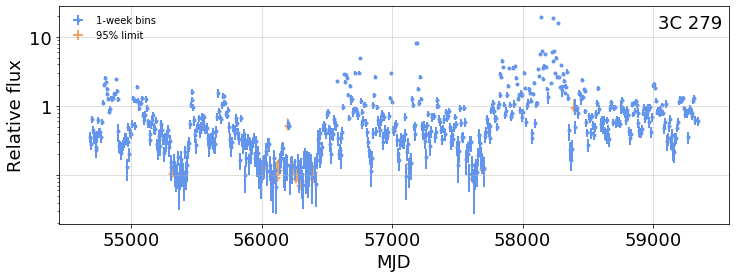

In [ ]:
wtl.plot(log=True);